In [9]:
import cooler
import cooltools.expected
import bioframe
import cooltools.eigdecomp
import cooltools.lib.numutils
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import seaborn as sns
plt.rcParams.update({'font.size': 16})
saveDir='../outputs/'

In [10]:
regionDf=pd.DataFrame(bioframe.fetch_chromsizes('mm10'))
regionDf['start']=0
regionDf=regionDf[['start','length']]
regionDf.reset_index(inplace=True)
regionDf.rename(columns={'length':'end','index':'chrom'},inplace=True)

ES=cooler.Cooler('../data/coolers/ES.mcool::resolutions/20000') #From Bonev et al 2017
bins = ES.bins()[:]
fasta_records = bioframe.load_fasta('../data/genomeInfo/mm10.fa')
bins = bioframe.genomeops.frac_gc(bins, fasta_records)

eigVal,eigVec=cooltools.eigdecomp.cooler_cis_eig(ES, bins=bins,phasing_track_col='GC')

meioticCoolersDict={
'zygonema':cooler.Cooler('../data/coolers/zygonema.mcool::resolutions/20000'), #from Patel et al 2019
'pachynema':cooler.Cooler('../data/coolers/pachynema.mcool::resolutions/20000'), #from Patel et al 2019
'PAC':cooler.Cooler('../data/coolers/PAC.mcool::resolutions/20000'), #from Wang et al 2019
'PS':cooler.Cooler('../data/coolers/PS.mcool::resolutions/20000') #from Alavattam et al 2019
}


In [11]:
def plotCurves(cooler, E1=eigVec.E1, regionDf=regionDf, saveName=None):
    nonBbins=np.where(~(E1<0))[0]
    nonAbins=np.where(~(E1>0))[0]
    binSize=cooler.binsize
    cvd = cooltools.expected.diagsum(
        clr=cooler,
        regions=regionDf,
        transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']},
        bad_bins=nonAbins
    )
    lb_cvd, lb_slopes, lb_distbins = cooltools.expected.logbin_expected(cvd)
    lb_cvd_agg, lb_slopes_agg = cooltools.expected.combine_binned_expected(
        lb_cvd,
        binned_exp_slope=lb_slopes
    )
    fig, ax = plt.subplots(2,1)
    ax[0].loglog(lb_cvd_agg['diag.avg']*binSize,lb_cvd_agg['balanced.avg'],label='A-comp')
    ax[1].semilogx(lb_slopes_agg['diag.avg']*binSize,lb_slopes_agg.slope,label='A-comp')
    cvd = cooltools.expected.diagsum(
        clr=cooler,
        regions=regionDf,
        transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']},
        bad_bins=nonBbins
    )
    lb_cvd, lb_slopes, lb_distbins = cooltools.expected.logbin_expected(cvd)
    lb_cvd_agg, lb_slopes_agg = cooltools.expected.combine_binned_expected(
        lb_cvd,
        binned_exp_slope=lb_slopes
    )
    ax[0].loglog(lb_cvd_agg['diag.avg']*binSize,lb_cvd_agg['balanced.avg'],label='B-comp')
    ax[1].semilogx(lb_slopes_agg['diag.avg']*binSize,lb_slopes_agg.slope,label='B-comp')
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title(coolerKey)
    ax[0].set_ylabel('P(s)')
    ax[1].set_ylabel('P(s) slope')
    ax[1].set_xlabel('distance (bp)')
    if saveName is not None:
        fig.savefig(saveName)

/pollard/home/xiaofanj/miniconda3/envs/hic/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/pollard/home/xiaofanj/miniconda3/envs/hic/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/pollard/home/xiaofanj/miniconda3/envs/hic/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/pollard/home/xiaofanj/miniconda3/envs/hic/lib/python3.7/site-packages/matplotlib/cbook

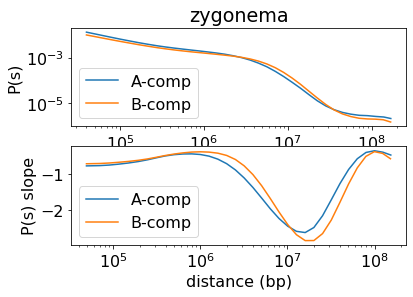

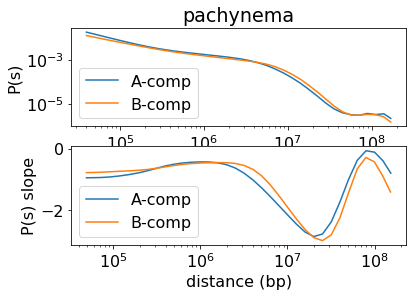

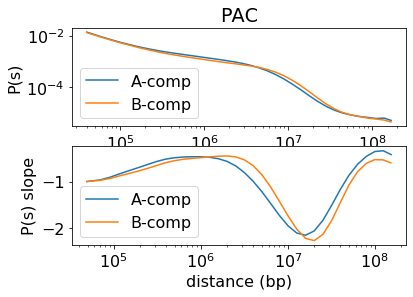

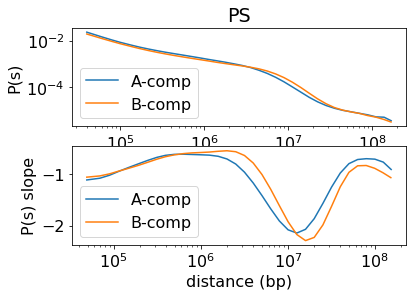

In [12]:
for coolerKey in meioticCoolersDict:
    plotCurves(meioticCoolersDict[coolerKey],saveName=f'{saveDir}/{coolerKey}_psCurves.pdf')

In [ ]:
mitotic30=cooler.Cooler('../data/coolers/GSM2745849_JHGHiC-DT40CDK1as-WT-20150609-30m-R1.10000.cool') #from Gibcus et al 2018
mitoticG2=cooler.Cooler('../data/coolers/GSM2745846_JHGHiC-DT40CDK1as-WT-20150609-G2-R1.10000.cool')

bins = mitoticG2.bins()[:]
fasta_records = bioframe.load_fasta('../data/genomeInfo/galGal5.fa')
bins = bioframe.genomeops.frac_gc(bins, fasta_records)
eigVal,eigVecGG5=cooltools.eigdecomp.cooler_cis_eig(mitoticG2, bins=bins,phasing_track_col='GC')

regionDfGG5=pd.read_csv('../data/genomeInfo/galGal5.chrom.sizes', header=None, delim_whitespace=True,names=['chrom','end'])
regionDfGG5['start']=0
regionDfGG5=regionDfGG5.loc[regionDfGG5.chrom.isin(eigVecGG5.chrom.unique()),:]
regionDfGG5=regionDfGG5.set_index('chrom').reindex(eigVecGG5.chrom.unique()).reset_index()[['chrom','start','end']]


In [ ]:
mitoticCoolersDict={
'mitotic30':mitotic30,
'mitoticG2':mitoticG2
}
for coolerKey in mitoticCoolersDict:
    plotCurves(mitoticCoolersDict[coolerKey], E1=eigVecGG5.E1, regionDf=regionDfGG5, saveName=f'{saveDir}/{coolerKey}_psCurves.pdf')